In [1]:
import pandas as pd

In [2]:
# Constantes
PREVIOUS_RESULTS_USED = 5
ACCEPTABLE_WINDOW = (PREVIOUS_RESULTS_USED + 1)//2
FIRST_ACCEPTED_RACE_NUMBER = 840 # Or None

In [3]:
raw_dfs = {
    'races': pd.read_parquet('.data_parquet/races.parquet'),
    'results': pd.read_parquet('.data_parquet/results.parquet'),
    'driver_standings': pd.read_parquet('.data_parquet/driver_standings.parquet'),
    'constructor_standings': pd.read_parquet('.data_parquet/constructor_standings.parquet'),
    'qualifying': pd.read_parquet('.data_parquet/qualifying.parquet')
}
display(raw_dfs['races'])

,year,round,circuitId,name,date,time,url,fp1_date,fp1_time,fp2_date,fp2_time,fp3_date,fp3_time,quali_date,quali_time,sprint_date,sprint_time,datetime
raceId,,,,,,,,,,,,,,,,,,
1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_G...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,2009-03-29 06:00:00
2,2009,2,2,Malaysian Grand Prix,2009-04-05,09:00:00,http://en.wikipedia.org/wiki/2009_Malaysian_Gr...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,2009-04-05 09:00:00
3,2009,3,17,Chinese Grand Prix,2009-04-19,07:00:00,http://en.wikipedia.org/wiki/2009_Chinese_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,2009-04-19 07:00:00
4,2009,4,3,Bahrain Grand Prix,2009-04-26,12:00:00,http://en.wikipedia.org/wiki/2009_Bahrain_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,2009-04-26 12:00:00
5,2009,5,4,Spanish Grand Prix,2009-05-10,12:00:00,http://en.wikipedia.org/wiki/2009_Spanish_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,2009-05-10 12:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1116,2023,18,69,United States Grand Prix,2023-10-22,19:00:00,https://en.wikipedia.org/wiki/2023_United_Stat...,2023-10-20,17:30:00,2023-10-21,18:00:00,\N,\N,2023-10-20,21:00:00,2023-10-21,22:00:00,2023-10-22 19:00:00
1117,2023,19,32,Mexico City Grand Prix,2023-10-29,20:00:00,https://en.wikipedia.org/wiki/2023_Mexico_City...,2023-10-27,18:30:00,2023-10-27,22:00:00,2023-10-28,17:30:00,2023-10-28,21:00:00,\N,\N,2023-10-29 20:00:00
1118,2023,20,18,São Paulo Grand Prix,2023-11-05,17:00:00,https://en.wikipedia.org/wiki/2023_S%C3%A3o_Pa...,2023-11-03,14:30:00,2023-11-04,14:30:00,\N,\N,2023-11-03,18:00:00,2023-11-04,18:30:00,2023-11-05 17:00:00


In [4]:
races_by_number = raw_dfs['races'][['year', 'round']].sort_values(['year', 'round'])
races_by_number['number'] = range(1, len(races_by_number) + 1)
races_number = races_by_number[['number']]
races_df_with_number = raw_dfs['races'].join(races_by_number['number'], on='raceId')
display(races_df_with_number)

,year,round,circuitId,name,date,time,url,fp1_date,fp1_time,fp2_date,fp2_time,fp3_date,fp3_time,quali_date,quali_time,sprint_date,sprint_time,datetime,number
raceId,,,,,,,,,,,,,,,,,,,
1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_G...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,2009-03-29 06:00:00,804
2,2009,2,2,Malaysian Grand Prix,2009-04-05,09:00:00,http://en.wikipedia.org/wiki/2009_Malaysian_Gr...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,2009-04-05 09:00:00,805
3,2009,3,17,Chinese Grand Prix,2009-04-19,07:00:00,http://en.wikipedia.org/wiki/2009_Chinese_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,2009-04-19 07:00:00,806
4,2009,4,3,Bahrain Grand Prix,2009-04-26,12:00:00,http://en.wikipedia.org/wiki/2009_Bahrain_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,2009-04-26 12:00:00,807
5,2009,5,4,Spanish Grand Prix,2009-05-10,12:00:00,http://en.wikipedia.org/wiki/2009_Spanish_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,2009-05-10 12:00:00,808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1116,2023,18,69,United States Grand Prix,2023-10-22,19:00:00,https://en.wikipedia.org/wiki/2023_United_Stat...,2023-10-20,17:30:00,2023-10-21,18:00:00,\N,\N,2023-10-20,21:00:00,2023-10-21,22:00:00,2023-10-22 19:00:00,1097
1117,2023,19,32,Mexico City Grand Prix,2023-10-29,20:00:00,https://en.wikipedia.org/wiki/2023_Mexico_City...,2023-10-27,18:30:00,2023-10-27,22:00:00,2023-10-28,17:30:00,2023-10-28,21:00:00,\N,\N,2023-10-29 20:00:00,1098
1118,2023,20,18,São Paulo Grand Prix,2023-11-05,17:00:00,https://en.wikipedia.org/wiki/2023_S%C3%A3o_Pa...,2023-11-03,14:30:00,2023-11-04,14:30:00,\N,\N,2023-11-03,18:00:00,2023-11-04,18:30:00,2023-11-05 17:00:00,1099


In [5]:
# Parâmetros pensados
# - Últimas posições de largada do piloto
# - Últimas posições de chegada do piloto
# - Histórico de classificação do piloto
# - Posição "média" de largada da equipe nas últimas corridas
# - Posição "média" de chegada da equipe nas últimas corridas
# - Histórico de classificação da equipe
# Agrupando todas as informações necessárias no df de resultados
results_df = raw_dfs['results']
joined_driver_standings_df = (
    raw_dfs['driver_standings'][['position']].rename(
        columns={'position': 'driver_standings_position'}
    )
)
joined_constructor_standings_df = (
    raw_dfs['constructor_standings'][['position']].rename(
        columns={'position': 'constructor_standings_position'}
    )
)
joined_race_df = (
    races_df_with_number[['number', 'year']]
)
results_df = results_df.join(joined_driver_standings_df)
results_df = results_df.join(joined_constructor_standings_df, on=['raceId', 'constructorId'])
results_df = results_df.join(joined_race_df)
if FIRST_ACCEPTED_RACE_NUMBER is not None:
    results_df = results_df.query('number >= @@FIRST_ACCEPTED_RACE_NUMBER').copy()
results_df = results_df.reset_index()
results_df = results_df.set_index(['driverId', 'number'])
results_df['driverId'] = results_df.index.get_level_values(0)
results_df = results_df.sort_index()
results_df['driverId_shifted'] = results_df.groupby(level=0)['driverId'].shift(PREVIOUS_RESULTS_USED)
results_df['driverId_equals'] = results_df['driverId'] == results_df['driverId_shifted']
results_df['year_shifted'] = results_df['year'].shift(PREVIOUS_RESULTS_USED)
results_df['year_equals'] = results_df['year'] == results_df['year_shifted']
display(results_df)

raceId  constructorId  grid  position  points  laps  \
driverId number                                                        
1        840        841              1     2       2.0    18.0    58   
         841        842              1     2       8.0     4.0    56   
         842        843              1     3       1.0    25.0    56   
         843        844              1     4       4.0    12.0    58   
         844        845              1     3       2.0    18.0    66   
...                 ...            ...   ...       ...     ...   ...   
858      1087      1106              3    18       NaN     0.0     6   
         1088      1107              3    18      13.0     0.0    70   
         1089      1108              3    14      11.0     0.0    52   
         1090      1109              3    20       NaN     0.0    67   
         1091      1110              3    18      17.0     0.0    44   

                 milliseconds  fastestLap  rank fastestLapTime  ... statusId  \
driverId number                                                 ...            
1        840        5392556.0        41.0   8.0       1:30.314  ...        1   
         841        5929789.0        54.0   5.0       1:41.512  ...        1   
         842        5818226.0        48.0   2.0       1:40.415  ...        1   
         843        5457790.0        48.0   4.0       1:30.108  ...        1   
         844        5943931.0        52.0   1.0       1:26.727  ...        1   
...                       ...         ...   ...            ...  ...      ...   
858      1087             NaN         4.0  20.0       1:18.437  ...        5   
         1088             NaN        45.0  12.0       1:09.611  ...       11   
         1089       5140570.0        42.0  13.0       1:31.699  ...        1   
         1090             NaN        36.0  12.0       1:23.496  ...       31   
         1091       5054926.0        37.0   9.0       1:50.486  ...        1   

                 fastestLapMillis  driver_standings_position  \
driverId number                                                
1        840              90314.0                        2.0   
         841             101512.0                        3.0   
         842             100415.0                        2.0   
         843              90108.0                        2.0   
         844              86727.0                        2.0   
...                           ...                        ...   
858      1087             78437.0                       20.0   
         1088             69611.0                       19.0   
         1089             91699.0                       19.0   
         1090             83496.0                       19.0   
         1091            110486.0                       19.0   

                 constructor_standings_position  year  driverId  \
driverId number                                                   
1        840                                2.0  2011         1   
         841                                2.0  2011         1   
         842                                2.0  2011         1   
         843                                2.0  2011         1   
         844                                2.0  2011         1   
...                                         ...   ...       ...   
858      1087                               9.0  2023       858   
         1088                               9.0  2023       858   
         1089                               7.0  2023       858   
         1090                               7.0  2023       858   
         1091                               7.0  2023       858   

                 driverId_shifted  driverId_equals  year_shifted  year_equals  
driverId number                                                                
1        840                  NaN            False           NaN        False  
         841                  NaN            False           NaN        False  
         842  

In [6]:
tmp_df = raw_dfs['results']
tmp_df = tmp_df.reset_index()
tmp_df = tmp_df.set_index(['raceId', 'constructorId']).sort_index()
tmp_df = (
    tmp_df
    .groupby(['raceId', 'constructorId'])
    [['grid', 'position']]
    .mean()
)
tmp_df = tmp_df.rename(columns={
    'grid': 'equivalent_grid_constructor',
    'position': 'equivalent_position_constructor'
})
tmp_df

equivalent_grid_constructor  \
raceId constructorId                                
1      1                                     15.0   
       2                                      6.5   
       3                                      8.0   
       4                                     12.0   
       5                                     15.0   
...                                           ...   
1110   117                                    9.5   
       131                                    5.5   
       210                                    8.0   
       213                                   15.0   
       214                                   13.0   

                      equivalent_position_constructor  
raceId constructorId                                   
1      1                                          NaN  
       2                                         12.0  
       3                                          6.0  
       4                                          5.0  
       5                                          7.5  
...                                               ...  
1110   117                                        7.0  
       131                                        5.0  
       210                                       16.5  
       213                                       13.0  
       214                                        9.5  

[12688 rows x 2 columns]

In [7]:
results_df = results_df.join(tmp_df, on=['raceId', 'constructorId'])
results_df

raceId  constructorId  grid  position  points  laps  \
driverId number                                                        
1        840        841              1     2       2.0    18.0    58   
         841        842              1     2       8.0     4.0    56   
         842        843              1     3       1.0    25.0    56   
         843        844              1     4       4.0    12.0    58   
         844        845              1     3       2.0    18.0    66   
...                 ...            ...   ...       ...     ...   ...   
858      1087      1106              3    18       NaN     0.0     6   
         1088      1107              3    18      13.0     0.0    70   
         1089      1108              3    14      11.0     0.0    52   
         1090      1109              3    20       NaN     0.0    67   
         1091      1110              3    18      17.0     0.0    44   

                 milliseconds  fastestLap  rank fastestLapTime  ...  \
driverId number                                                 ...   
1        840        5392556.0        41.0   8.0       1:30.314  ...   
         841        5929789.0        54.0   5.0       1:41.512  ...   
         842        5818226.0        48.0   2.0       1:40.415  ...   
         843        5457790.0        48.0   4.0       1:30.108  ...   
         844        5943931.0        52.0   1.0       1:26.727  ...   
...                       ...         ...   ...            ...  ...   
858      1087             NaN         4.0  20.0       1:18.437  ...   
         1088             NaN        45.0  12.0       1:09.611  ...   
         1089       5140570.0        42.0  13.0       1:31.699  ...   
         1090             NaN        36.0  12.0       1:23.496  ...   
         1091       5054926.0        37.0   9.0       1:50.486  ...   

                driver_standings_position  constructor_standings_position  \
driverId number                                                             
1        840                          2.0                             2.0   
         841                          3.0                             2.0   
         842                          2.0                             2.0   
         843                          2.0                             2.0   
         844                          2.0                             2.0   
...                                   ...                             ...   
858      1087                        20.0                             9.0   
         1088                        19.0                             9.0   
         1089                        19.0                             7.0   
         1090                        19.0                             7.0   
         1091                        19.0                             7.0   

                 year  driverId  driverId_shifted  driverId_equals  \
driverId number                                                      
1        840     2011         1               NaN            False   
         841     2011         1               NaN            False   
         842     2011         1               NaN            False   
         843     2011         1               NaN            False   
         844     2011         1               NaN            False   
...               ...       ...               ...              ...   
858      1087    2023       858             858.0             True   
         1088    2023       858             858.0             True   
         1089    2023       858             858.0             True   
         1090    2023       858             858.0             True   
         1091    2023       858             858.0             True   

                 year_shifted  year_equals  equivalent_grid_constructor  \
driverId number                                                           
1        840              NaN        False                          3.0   
         841      

In [8]:
tmp2_df = (
    results_df[[
        'grid',
        'equivalent_grid_constructor',
    ]]
    .rolling(PREVIOUS_RESULTS_USED)
    .agg(['mean', 'std'])
    .rename(columns={
        'grid': 'grid_driver'
    })
).shift(1)
tmp2_df.columns = ['_'.join(col).strip() for col in tmp2_df.columns.values]
display(tmp2_df.head(10))

grid_driver_mean  grid_driver_std  \
driverId number                                      
1        840                  NaN              NaN   
         841                  NaN              NaN   
         842                  NaN              NaN   
         843                  NaN              NaN   
         844                  NaN              NaN   
         845                  2.8         0.836660   
         846                  4.2         2.774887   
         847                  4.8         2.489980   
         848                  4.8         2.489980   
         849                  6.0         3.316625   

                 equivalent_grid_constructor_mean  \
driverId number                                     
1        840                                  NaN   
         841                                  NaN   
         842                                  NaN   
         843                                  NaN   
         844                                  NaN   
         845                                  3.5   
         846                                  4.0   
         847                                  4.6   
         848                                  5.0   
         849                                  5.5   

                 equivalent_grid_constructor_std  
driverId number                                   
1        840                                 NaN  
         841                                 NaN  
         842                                 NaN  
         843                                 NaN  
         844                                 NaN  
         845                            1.000000  
         846                            1.274755  
         847                            1.387444  
         848                            0.790569  
         849                            1.369306

In [9]:
tmp3_df = (
    results_df[[
        'position',
        'equivalent_position_constructor',
    ]]
    .rolling(PREVIOUS_RESULTS_USED, min_periods=ACCEPTABLE_WINDOW)
    .agg(['mean', 'std'])
    .rename(columns={
        'position': 'position_driver',
    })
).shift(1)
tmp3_df.columns = ['_'.join(col).strip() for col in tmp3_df.columns.values]
display(tmp3_df.head(10))

position_driver_mean  position_driver_std  \
driverId number                                              
1        840                      NaN                  NaN   
         841                      NaN                  NaN   
         842                      NaN                  NaN   
         843                 3.666667             3.785939   
         844                 3.750000             3.095696   
         845                 3.400000             2.792848   
         846                 4.200000             2.863564   
         847                 3.250000             2.217356   
         848                 4.000000             1.632993   
         849                 4.000000             1.632993   

                 equivalent_position_constructor_mean  \
driverId number                                         
1        840                                      NaN   
         841                                      NaN   
         842                                      NaN   
         843                                 3.833333   
         844                                 4.125000   
         845                                 3.800000   
         846                                 3.900000   
         847                                 3.100000   
         848                                 3.600000   
         849                                 3.400000   

                 equivalent_position_constructor_std  
driverId number                                       
1        840                                     NaN  
         841                                     NaN  
         842                                     NaN  
         843                                1.258306  
         844                                1.181454  
         845                                1.254990  
         846                                1.294218  
         847                                1.635543  
         848                                1.781853  
         849                                1.635543

In [10]:
results_df = results_df.join(tmp2_df)
results_df = results_df.join(tmp3_df)
results_df

raceId  constructorId  grid  position  points  laps  \
driverId number                                                        
1        840        841              1     2       2.0    18.0    58   
         841        842              1     2       8.0     4.0    56   
         842        843              1     3       1.0    25.0    56   
         843        844              1     4       4.0    12.0    58   
         844        845              1     3       2.0    18.0    66   
...                 ...            ...   ...       ...     ...   ...   
858      1087      1106              3    18       NaN     0.0     6   
         1088      1107              3    18      13.0     0.0    70   
         1089      1108              3    14      11.0     0.0    52   
         1090      1109              3    20       NaN     0.0    67   
         1091      1110              3    18      17.0     0.0    44   

                 milliseconds  fastestLap  rank fastestLapTime  ...  \
driverId number                                                 ...   
1        840        5392556.0        41.0   8.0       1:30.314  ...   
         841        5929789.0        54.0   5.0       1:41.512  ...   
         842        5818226.0        48.0   2.0       1:40.415  ...   
         843        5457790.0        48.0   4.0       1:30.108  ...   
         844        5943931.0        52.0   1.0       1:26.727  ...   
...                       ...         ...   ...            ...  ...   
858      1087             NaN         4.0  20.0       1:18.437  ...   
         1088             NaN        45.0  12.0       1:09.611  ...   
         1089       5140570.0        42.0  13.0       1:31.699  ...   
         1090             NaN        36.0  12.0       1:23.496  ...   
         1091       5054926.0        37.0   9.0       1:50.486  ...   

                equivalent_grid_constructor  equivalent_position_constructor  \
driverId number                                                                
1        840                            3.0                              4.0   
         841                            3.0                              5.0   
         842                            2.5                              2.5   
         843                            5.0                              5.0   
         844                            4.0                              2.5   
...                                     ...                              ...   
858      1087                          13.5                              7.0   
         1088                          14.0                             12.0   
         1089                          11.0                              9.5   
         1090                          18.0                             11.0   
         1091                          16.5                             15.5   

                 grid_driver_mean  grid_driver_std  \
driverId number                                      
1        840                  NaN              NaN   
         841                  NaN              NaN   
         842                  NaN              NaN   
         843                  NaN              NaN   
         844                  NaN              NaN   
...                           ...              ...   
858      1087                17.6         2.607681   
         1088                17.6         2.607681   
         1089                18.4         1.673320   
         1090                17.2         2.280351   
         1091                18.0         2.449490   

                 equivalent_grid_constructor_mean  \
driverId number                                     
1        840                                  NaN   
         841                                  NaN   
         842                                  NaN   
         843                                  NaN   
         844                                  NaN   
...                                      

In [11]:
results_df.columns

Index(['raceId', 'constructorId', 'grid', 'position', 'points', 'laps',
       'milliseconds', 'fastestLap', 'rank', 'fastestLapTime',
       'fastestLapSpeed', 'statusId', 'fastestLapMillis',
       'driver_standings_position', 'constructor_standings_position', 'year',
       'driverId', 'driverId_shifted', 'driverId_equals', 'year_shifted',
       'year_equals', 'equivalent_grid_constructor',
       'equivalent_position_constructor', 'grid_driver_mean',
       'grid_driver_std', 'equivalent_grid_constructor_mean',
       'equivalent_grid_constructor_std', 'position_driver_mean',
       'position_driver_std', 'equivalent_position_constructor_mean',
       'equivalent_position_constructor_std'],
      dtype='object')

In [12]:
tt_df = results_df.drop(columns=[
    'raceId', 'constructorId', 'points', 'laps',
    'milliseconds', 'fastestLap', 'rank', 'fastestLapTime',
    'fastestLapSpeed', 'statusId', 'year', 'driverId',
    'driverId_shifted', 'year_shifted', 'equivalent_grid_constructor',
    'equivalent_position_constructor', 'fastestLapMillis'
])
x_columns = tt_df.columns.difference(['position'])
y_columns = ['position']
columns_in_order = list(x_columns) + y_columns
tt_df = tt_df[columns_in_order]
tt_df.shape

(5301, 14)

In [13]:
tt_df[tt_df['driverId_equals'] & tt_df['year_equals']]

constructor_standings_position  driverId_equals  \
driverId number                                                    
1        845                                2.0             True   
         846                                2.0             True   
         847                                2.0             True   
         848                                2.0             True   
         849                                2.0             True   
...                                         ...              ...   
858      1087                               9.0             True   
         1088                               9.0             True   
         1089                               7.0             True   
         1090                               7.0             True   
         1091                               7.0             True   

                 driver_standings_position  equivalent_grid_constructor_mean  \
driverId number                                                                
1        845                           2.0                               3.5   
         846                           4.0                               4.0   
         847                           4.0                               4.6   
         848                           4.0                               5.0   
         849                           3.0                               5.5   
...                                    ...                               ...   
858      1087                         20.0                              15.0   
         1088                         19.0                              15.1   
         1089                         19.0                              15.3   
         1090                         19.0                              14.4   
         1091                         19.0                              15.1   

                 equivalent_grid_constructor_std  \
driverId number                                    
1        845                            1.000000   
         846                            1.274755   
         847                            1.387444   
         848                            0.790569   
         849                            1.369306   
...                                          ...   
858      1087                           2.474874   
         1088                           2.382226   
         1089                           2.196588   
         1090                           2.902585   
         1091                           3.324154   

                 equivalent_position_constructor_mean  \
driverId number                                         
1        845                                      3.8   
         846                                      3.9   
         847                                      3.1   
         848                                      3.6   
         849                                      3.4   
...                                               ...   
858      1087                                    16.2   
         1088                                    14.4   
         1089                                    14.0   
         1090                                    12.5   
         1091                                    11.5   

                 equivalent_position_constructor_std  grid  grid_driver_mean  \
driverId number                                                                
1        845                                1.254990     9               2.8   
         846                                1.294218     5               4.2   
         847                                1.635543     3               4.8   
         848                                1.781853    10               4.8   
         849                                1.635543     2               6.0   
...                                              ...   ...               ...   
858      1087                   

In [14]:
tt_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5301 entries, (1, 840) to (858, 1091)
Data columns (total 14 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   constructor_standings_position        5295 non-null   float64
 1   driverId_equals                       5301 non-null   bool   
 2   driver_standings_position             5297 non-null   float64
 3   equivalent_grid_constructor_mean      5296 non-null   float64
 4   equivalent_grid_constructor_std       5296 non-null   float64
 5   equivalent_position_constructor_mean  5294 non-null   float64
 6   equivalent_position_constructor_std   5294 non-null   float64
 7   grid                                  5301 non-null   int64  
 8   grid_driver_mean                      5296 non-null   float64
 9   grid_driver_std                       5296 non-null   float64
 10  position_driver_mean                  5113 non-null   float64
 11  pos

In [15]:
tt_df.dropna().shape

(4299, 14)

In [16]:
tt_df[tt_df['driverId_equals'] & tt_df['year_equals']].dropna().shape

(3169, 14)

In [17]:
import numpy as np

tt_df = tt_df[tt_df['driverId_equals'] & tt_df['year_equals']].dropna()
tt_df = tt_df.drop(columns=['driverId_equals', 'year_equals'])
tt_size = tt_df.shape[0]
train_size = int(tt_size * (2/3))
test_size = tt_size - train_size
idxs = np.random.permutation(tt_size)
train_df = tt_df.iloc[idxs[:train_size]].copy()
test_df = tt_df.iloc[idxs[train_size:]].copy()
x_columns = tt_df.columns.difference(['position'])
y_columns = ['position']

In [18]:
# from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)
train_df_with_poly = poly.fit_transform(train_df[x_columns])
reg = HuberRegressor(max_iter=int(1e6))
reg.fit(train_df_with_poly, train_df[y_columns])

/home/guilherme/Projects/personal/data-science-uni/.env/lib/python3.12/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


HuberRegressor(max_iter=1000000)

In [19]:
test_df_with_poly = poly.fit_transform(test_df[x_columns])
y_pred = reg.predict(test_df_with_poly)
test_df['predicted_position'] = y_pred.round()

In [20]:
# mse position and predicted_position
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(test_df['position'], test_df['predicted_position'])
mae = mean_absolute_error(test_df['position'], test_df['predicted_position'])
display(mse, mae)

8.976348155156103

2.192999053926206

In [21]:
test_df['delta'] = test_df['predicted_position'] - test_df['position']

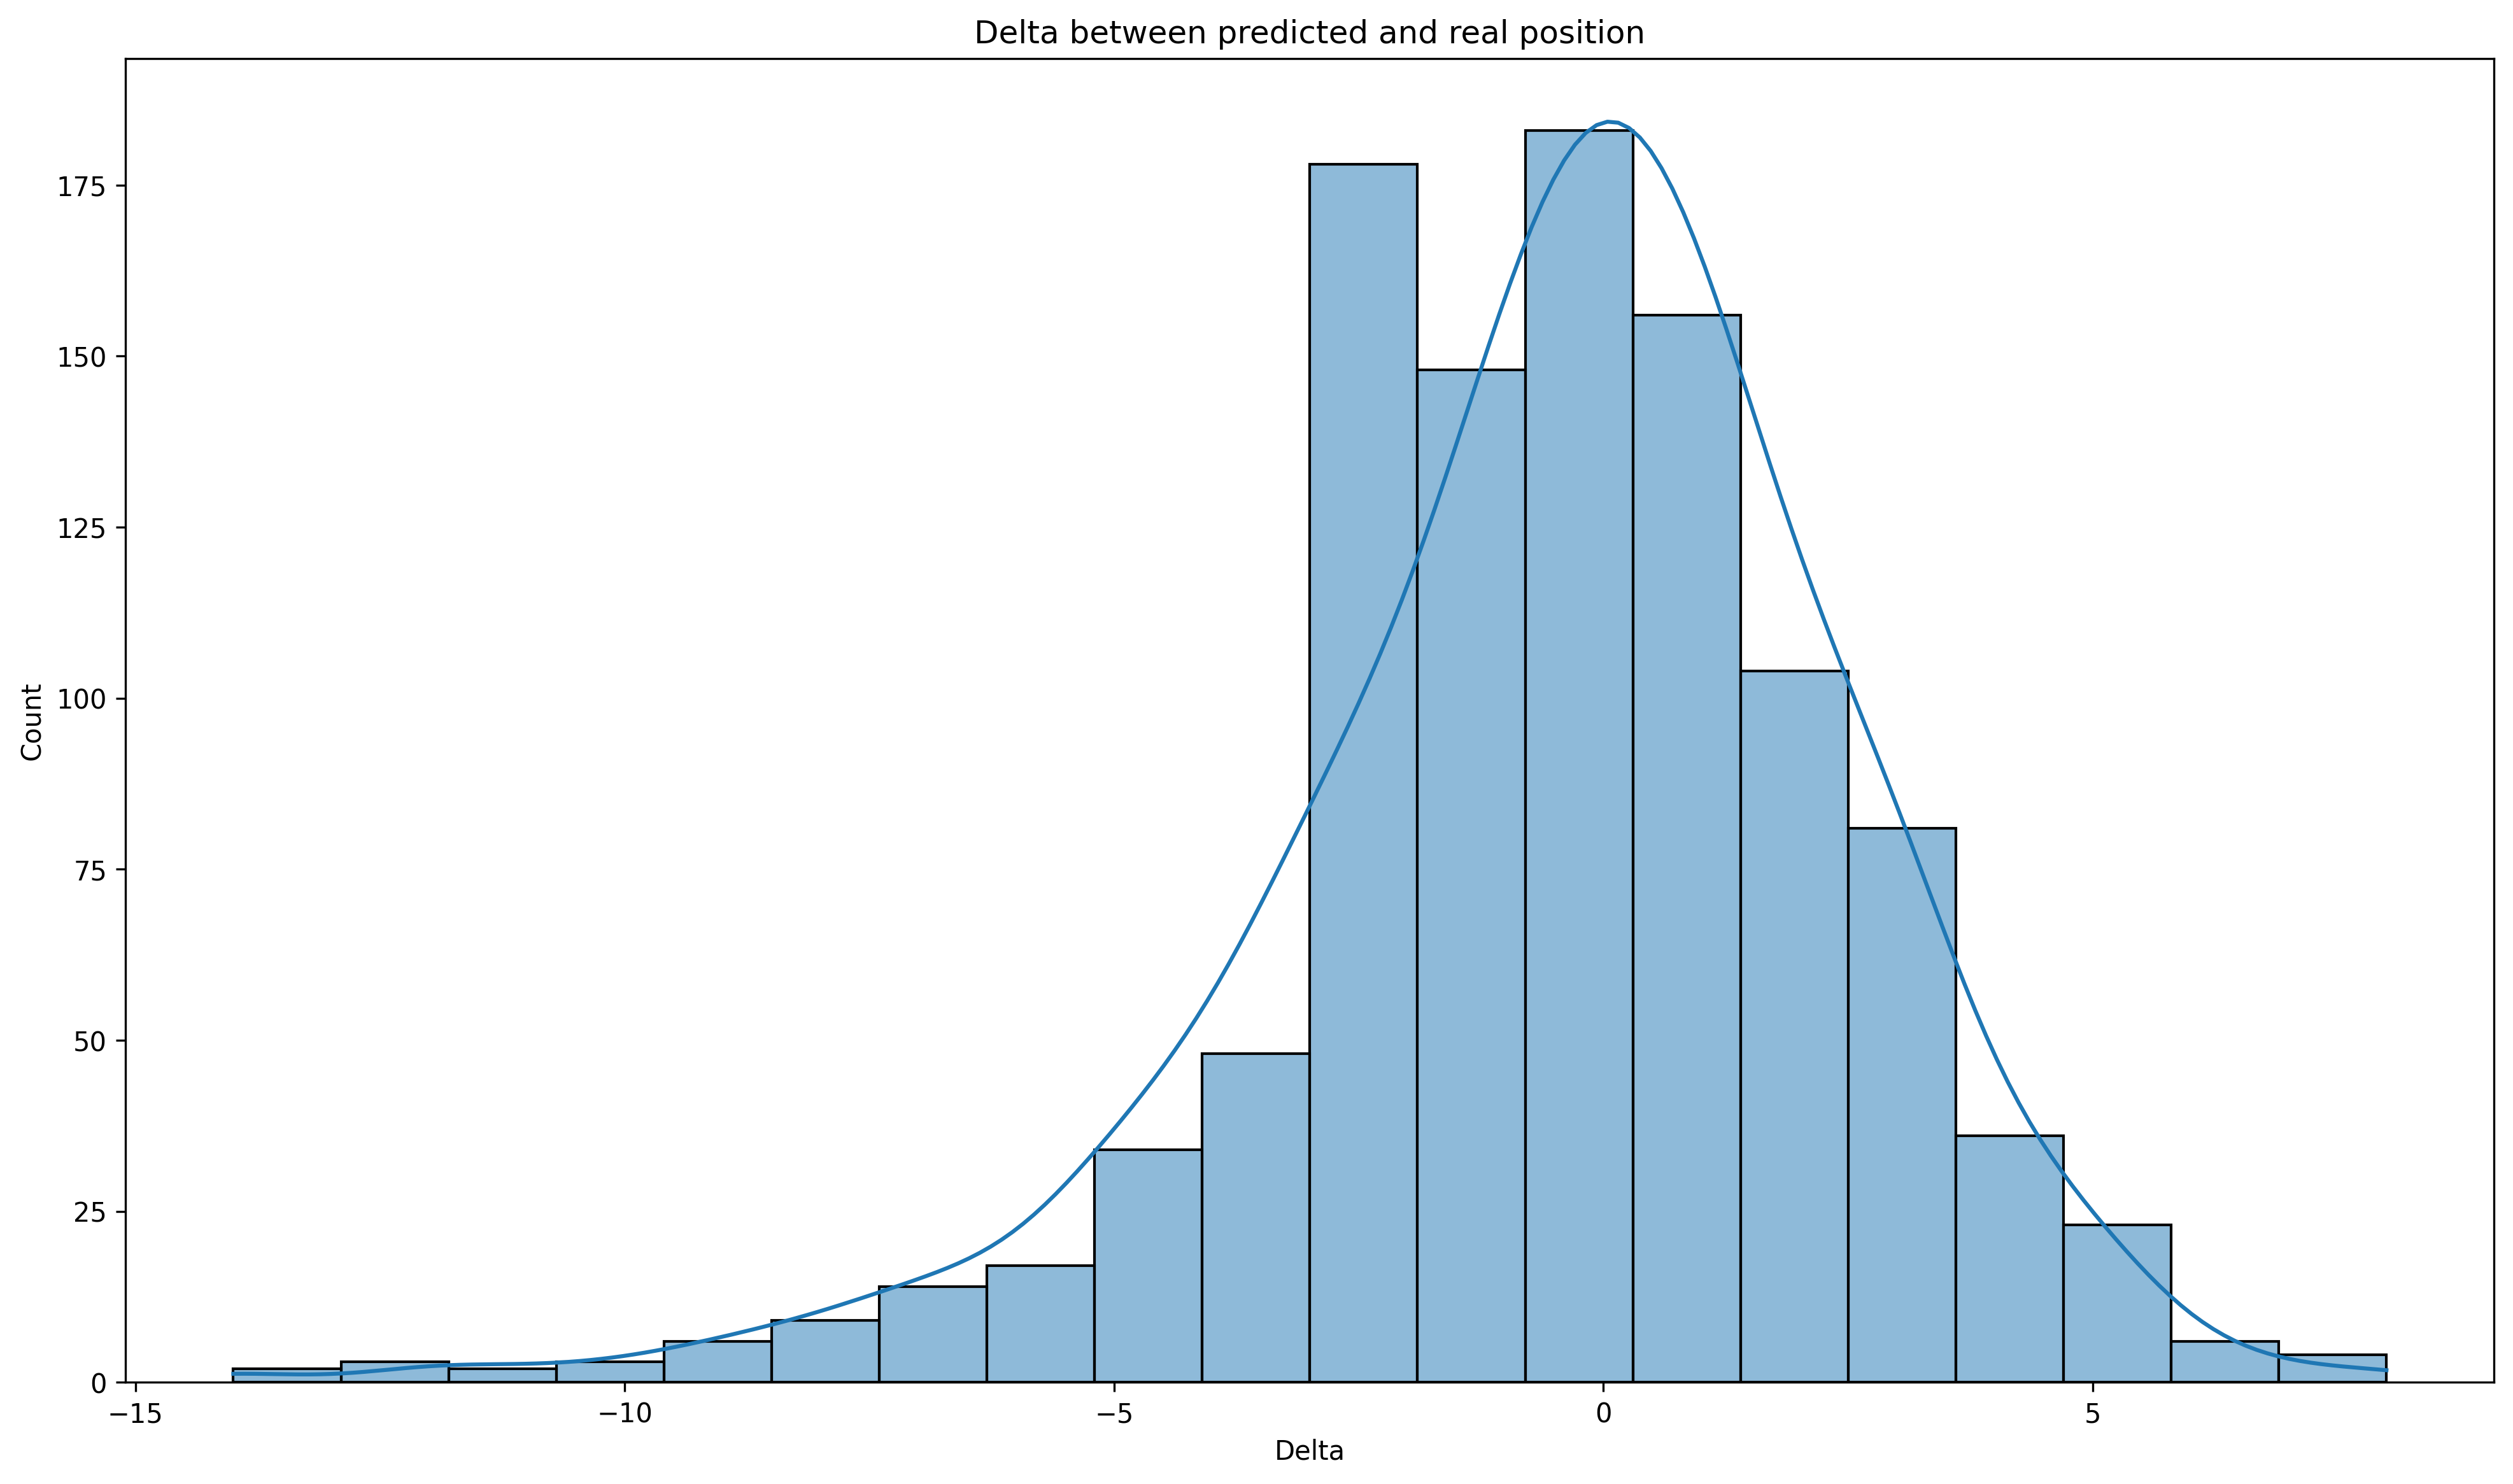

In [22]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.dpi'] = 300
fig, ax = plt.subplots(figsize=(16,9))
sns.histplot(test_df['delta'], bins=20, kde=True, ax=ax)
ax.set_xlabel('Delta')
ax.set_ylabel('Count')
ax.set_title('Delta between predicted and real position')
plt.show()

In [23]:
test_df.groupby('position')[['predicted_position', 'delta']].agg(['mean', 'min', 'max', 'std'])

predicted_position                           delta             \
                       mean   min   max       std      mean   min  max   
position                                                                 
1.0                2.200000   1.0   9.0  1.379748  1.200000   0.0  8.0   
2.0                3.551020   1.0   9.0  1.826440  1.551020  -1.0  7.0   
3.0                3.842105   1.0  11.0  1.705306  0.842105  -2.0  8.0   
4.0                4.660377   2.0  11.0  1.697775  0.660377  -2.0  7.0   
5.0                5.474576   2.0  11.0  2.037205  0.474576  -3.0  6.0   
6.0                6.524590   3.0  12.0  1.902687  0.524590  -3.0  6.0   
7.0                7.750000   2.0  12.0  2.605232  0.750000  -5.0  5.0   
8.0                8.654545   4.0  14.0  2.743465  0.654545  -4.0  6.0   
9.0                9.323077   3.0  15.0  2.622664  0.323077  -6.0  6.0   
10.0              10.016667   3.0  15.0  2.664848  0.016667  -7.0  5.0   
11.0              10.500000   4.0  16.0  2.783250 -0.500000  -7.0  5.0   
12.0              11.640625   4.0  17.0  2.983378 -0.359375  -8.0  5.0   
13.0              11.950820   5.0  18.0  2.722904 -1.049180  -8.0  5.0   
14.0              11.901408   2.0  17.0  3.439912 -2.098592 -12.0  3.0   
15.0              13.317460   7.0  19.0  2.710942 -1.682540  -8.0  4.0   
16.0              13.100000   4.0  19.0  3.506770 -2.900000 -12.0  3.0   
17.0              14.027778   3.0  18.0  3.476337 -2.972222 -14.0  1.0   
18.0              15.228571   9.0  19.0  2.462492 -2.771429  -9.0  1.0   
19.0              14.647059   5.0  18.0  3.516767 -4.352941 -14.0 -1.0   
20.0              15.571429  11.0  20.0  3.101459 -4.428571  -9.0  0.0   
21.0              16.250000  12.0  18.0  2.872281 -4.750000  -9.0 -3.0   
22.0              17.400000  12.0  21.0  3.361547 -4.600000 -10.0 -1.0   
23.0              19.000000  19.0  19.0       NaN -4.000000  -4.0 -4.0   

                    
               std  
position            
1.0       1.379748  
2.0       1.826440  
3.0       1.705306  
4.0       1.697775  
5.0       2.037205  
6.0       1.902687  
7.0       2.605232  
8.0       2.743465  
9.0       2.622664  
10.0      2.664848  
11.0      2.783250  
12.0      2.983378  
13.0      2.722904  
14.0      3.439912  
15.0      2.710942  
16.0      3.506770  
17.0      3.476337  
18.0      2.462492  
19.0      3.516767  
20.0      3.101459  
21.0      2.872281  
22.0      3.361547  
23.0           NaN